In [1]:
# Import packages
import numpy as np
import pandas as pd
import random as random
import matplotlib.pyplot as plt
import scipy

# from tqdm import tqdm
import seaborn as sns

# load in bettor objects

from bettor import bettor, run_market, plot_returns, run_market_fixed_el, gen_election

In [2]:
from statsmodels.tsa.stattools import grangercausalitytests

In [3]:
from matplotlib.colors import LinearSegmentedColormap

In [4]:
colors = [
    "#CC99FF",  # lavender purple (existing)
    "#000080",  # navy blue (existing)
    "#339966",  # forest green (existing)
    "#F4A261",  # muted orange
    "#B22222",  # deep ruby red
    "#6A4C93",  # royal violet
    "#1D3557",  # dark indigo
    "#2A9D8F",  # teal
    "#457B9D",   # steel blue,
    "#FFB347",  # warm amber/orange
    "#E63946"  # deep crimson red
]

# define mpl colourmap
cmap= LinearSegmentedColormap.from_list("power_predictioncmap", colors)

In [5]:
from collections.abc import Iterable

# need a function to flatten irregular list of lists
def flatten(xs):
    for x in xs:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            yield from flatten(x)
        else:
            yield x

In [7]:
import statsmodels.api as sm

In [8]:
 def best_lag_regression(market, outcome, max_lag=30, criterion='pval'):
    """
    Find the lag l that gives the best predictive regression:
        eta_t = beta * m_{t-l} + error_t

    Parameters
    ----------
    market : array-like
        Market price time series (m_t)
    outcome : array-like
        True outcome time series (η_t)
    max_lag : int, optional
        Maximum lag (in time steps) to test
    criterion : {'pval', 'r2'}, optional
        Select best model based on lowest p-value or highest R^2.

    Returns
    -------
    results : dict
        Dictionary containing best lag, beta coefficient, p-value, R^2, and full summary.
    """
    market = np.asarray(market)
    outcome = np.asarray(outcome)
    n = len(outcome)

    best = {'lag': None, 'beta': None, 'pval': np.inf, 'r2': -np.inf, 'model': None}

    for lag in range(1, max_lag + 1):
        y = outcome[lag:]           # η_t
        x = market[:-lag]           # m_{t-l}
        x = sm.add_constant(x)
        model = sm.OLS(y, x).fit()
        beta_pval = model.pvalues[1]
        beta_coef = model.params[1]
        r2 = model.rsquared

        if criterion == 'pval':
            if beta_pval < best['pval']:
                best.update({'lag': lag, 'beta': beta_coef, 'pval': beta_pval, 'r2': r2, 'model': model})
        elif criterion == 'r2':
            if r2 > best['r2']:
                best.update({'lag': lag, 'beta': beta_coef, 'pval': beta_pval, 'r2': r2, 'model': model})

    return best

In [9]:
def evaluate_markets(market_record, maxlag=5):
    mp = np.array(market_record['price_history'])
    tp = np.array(market_record['gen_el'])

    # take first differences
    tp_diff = np.diff(tp)
    mp_diff = np.diff(mp)
    ts_data = np.column_stack([mp_diff, tp_diff])

    mse = np.mean((mp-tp)**2)

    best_lag = best_lag_regression(mp, tp)

    # res = grangercausalitytests(ts_data, maxlag=maxlag, addconst=True, verbose=False)

    # # pull p-values from one of the tests at each lag (e.g., ssr_ftest)
    # pvals = {lag: res[lag][0]['ssr_ftest'][1] for lag in res}

    # # decide significance at, say, 5%
    # sig_lags = [lag for lag, p in pvals.items() if p < 0.05]
    # # best_lag = min(sig_lags) if sig_lags else None

    # # get lag with lowest p-value
    # if pvals:
    #     best_lag = min(pvals, key=pvals.get)
    # else:
    #     best_lag = None

    return mse, best_lag

In [10]:
# Global parameters

N_bettors = 100
T_max = 100
initial_price = 0.5
rw_variance = 0.05

# number of iterations for each set of parameters
n_iter_ = 30

In [11]:
# Set initial input values to the betting market function
parameters = {'n_bettors': N_bettors, # The number of betting agents
                #'el_outcome': 1, # Q: Ultimate election outcome - assuming we know this to begin with and it does not change over time...for now this is implemented as a random walk of the probability...but should this be 0 or 1 instead? '''
            't_election': T_max, # Time until election takes place (ie. time horizon of betting)
            'initial_price': initial_price, # Initial market price (is this equivalent to probability of winning)
            'outcome_uncertainty': rw_variance} # This is a measure of how uncertain the true outcome is - ie. the volatility of the random walk election probability

parameters.update({'bettors': [bettor(budget=100) for _ in range(parameters['n_bettors'])] + [bettor(budget=200, market_valuation=1,whale=True)]})


In [12]:
market_record = run_market(**parameters)

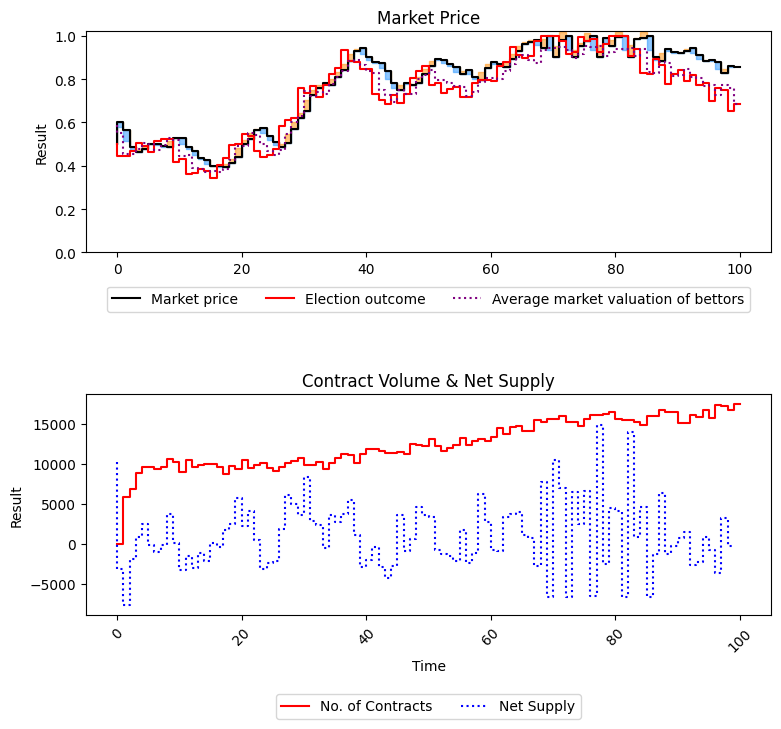

In [13]:
plot_returns(market_record, scale_fact=15, step=True)

# Plot 1 - parameter sweep
- Increasing expertise (we expect this reduces error)
- Increasing bias
- Increasing the correlation of budget and bias (choose a value from previous plot)
- Increasing variance of budget
- Increasing average risk adversity
- Increasing stubbornness

In [14]:
results_dict = {}

In [15]:
# set seed
np.random.seed(0)

results = []

# Set initial input values to the betting market function
parameters = {'n_bettors': N_bettors, # The number of betting agents
                #'el_outcome': 1, # Q: Ultimate election outcome - assuming we know this to begin with and it does not change over time...for now this is implemented as a random walk of the probability...but should this be 0 or 1 instead? '''
            't_election': T_max, # Time until election takes place (ie. time horizon of betting)
            'initial_price': initial_price, # Initial market price (is this equivalent to probability of winning)
            'outcome_uncertainty': rw_variance} # This is a measure of how uncertain the true outcome is - ie. the volatility of the random walk election probability


for e in np.arange(0,1.1,0.1):
    parameters.update({'bettors': [bettor(expertise=e) for _ in range(parameters['n_bettors'])]})
    for _ in range(n_iter_):
        market_record = run_market(**parameters)
        mse, min_sig_lag = evaluate_markets(market_record)
        results.append([e, mse, min_sig_lag])

results_dict['expertise'] = np.array(results)

In [16]:
# set seed
np.random.seed(0)

results = []

# Set initial input values to the betting market function
parameters = {'n_bettors': N_bettors, # The number of betting agents
                #'el_outcome': 1, # Q: Ultimate election outcome - assuming we know this to begin with and it does not change over time...for now this is implemented as a random walk of the probability...but should this be 0 or 1 instead? '''
            't_election': T_max, # Time until election takes place (ie. time horizon of betting)
            'initial_price': initial_price, # Initial market price (is this equivalent to probability of winning)
            'outcome_uncertainty': rw_variance} # This is a measure of how uncertain the true outcome is - ie. the volatility of the random walk election probability


for b in np.arange(-0.3,0.3,0.05):
    parameters.update({'bettors': [bettor(bias=b) for _ in range(parameters['n_bettors'])]})
    for _ in range(n_iter_):
        market_record = run_market(**parameters)
        mse, min_sig_lag = evaluate_markets(market_record)
        results.append([b, mse, min_sig_lag])

results_dict['bias'] = np.array(results)

In [17]:
# set seed
np.random.seed(0)

results = []

# Set initial input values to the betting market function
parameters = {'n_bettors': N_bettors, # The number of betting agents
                #'el_outcome': 1, # Q: Ultimate election outcome - assuming we know this to begin with and it does not change over time...for now this is implemented as a random walk of the probability...but should this be 0 or 1 instead? '''
            't_election': T_max, # Time until election takes place (ie. time horizon of betting)
            'initial_price': initial_price, # Initial market price (is this equivalent to probability of winning)
            'outcome_uncertainty': rw_variance} # This is a measure of how uncertain the true outcome is - ie. the volatility of the random walk election probability


for ra in np.arange(0,1.1,0.1):
    parameters.update({'bettors': [bettor(risk_av=ra) for _ in range(parameters['n_bettors'])]})
    for _ in range(n_iter_):
        market_record = run_market(**parameters)
        mse, min_sig_lag = evaluate_markets(market_record)
        results.append([ra, mse, min_sig_lag])

results_dict['risk_adversity'] = np.array(results)

In [18]:
# set seed
np.random.seed(0)

results = []


# Set initial input values to the betting market function
parameters = {'n_bettors': N_bettors, # The number of betting agents
                #'el_outcome': 1, # Q: Ultimate election outcome - assuming we know this to begin with and it does not change over time...for now this is implemented as a random walk of the probability...but should this be 0 or 1 instead? '''
            't_election': T_max, # Time until election takes place (ie. time horizon of betting)
            'initial_price': initial_price, # Initial market price (is this equivalent to probability of winning)
            'outcome_uncertainty': rw_variance} # This is a measure of how uncertain the true outcome is - ie. the volatility of the random walk election probability

for s in np.arange(0.05,1,0.05):
    parameters.update({'bettors': [bettor(stubbornness=s) for _ in range(parameters['n_bettors'])]})
    for _ in range(n_iter_):
        market_record = run_market(**parameters)
        mse, min_sig_lag = evaluate_markets(market_record)
        results.append([s, mse, min_sig_lag])

results_dict['stubbornness'] = np.array(results)

In [19]:
# set seed
np.random.seed(0)

results = []


# Set initial input values to the betting market function
parameters = {'n_bettors': N_bettors, # The number of betting agents
                #'el_outcome': 1, # Q: Ultimate election outcome - assuming we know this to begin with and it does not change over time...for now this is implemented as a random walk of the probability...but should this be 0 or 1 instead? '''
            't_election': T_max, # Time until election takes place (ie. time horizon of betting)
            'initial_price': initial_price, # Initial market price (is this equivalent to probability of winning)
            'outcome_uncertainty': rw_variance} # This is a measure of how uncertain the true outcome is - ie. the volatility of the random walk election probability

for v in np.arange(0,500,50):
    for _ in range(n_iter_):
        budget_samples = np.clip(np.random.normal(500, v, N_bettors),0,None)
        parameters.update({'bettors': [bettor(budget=budget_samples[i]) for i in range(parameters['n_bettors'])]})
    
        market_record = run_market(**parameters)
        mse, min_sig_lag = evaluate_markets(market_record)
        results.append([v, mse, min_sig_lag])
        
results_dict['budget_variance'] = np.array(results)

### Plots

In [27]:
results_dict_store = results_dict.copy()

In [ ]:
for k, v in results_dict.items():
    v[:,2] = [int(x['lag']) for x in v[:,2]]

Text(0.5, 1.0, 'Min Lag for Significant GC')

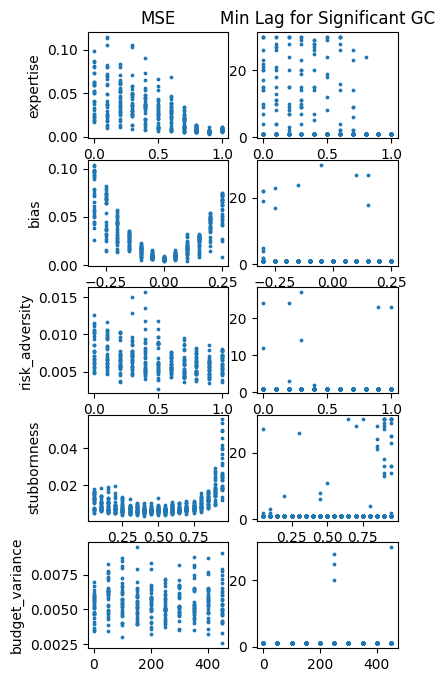

In [35]:
fig, ax = plt.subplots(len(results_dict.keys()),2,figsize=(4,8))
axs = ax.ravel()

i=0
for k in results_dict.keys():
#     arr=results_dict[k]
#     rows, row_pos = np.unique(arr[:, 0], return_inverse=True)
#     cols, col_pos = np.unique(arr[:, 1], return_inverse=True)
#     pivoted_arr3 = np.zeros((len(rows), len(cols)))
#     pivoted_arr3[row_pos, col_pos] = arr[:, 2]

#     axs[i].boxplot(pivoted_arr3.T,positions=rows)
    axs[i].scatter(x=results_dict[k][:,0],y=results_dict[k][:,1],s=3)
    axs[i].set_ylabel(k)
    
    i+=1
    axs[i].scatter(x=results_dict[k][:,0],y=results_dict[k][:,2],s=3)
    i+=1

axs[0].set_title('MSE')
axs[1].set_title('Min Lag for Significant GC')

In [36]:
arr = results_dict['expertise']

arr[:, 2]

array([1, 1, 21, 1, 1, 1, 1, 7, 23, 30, 9, 30, 10, 1, 1, 1, 15, 20, 4, 26,
       1, 1, 1, 14, 15, 22, 17, 20, 30, 14, 1, 1, 1, 1, 1, 1, 1, 1, 30,
       13, 18, 1, 21, 11, 15, 4, 10, 1, 20, 1, 11, 8, 30, 28, 27, 27, 10,
       26, 4, 1, 1, 1, 1, 1, 7, 1, 1, 1, 8, 20, 10, 3, 30, 30, 1, 7, 1,
       30, 28, 1, 1, 1, 1, 1, 15, 2, 9, 24, 15, 1, 1, 1, 1, 28, 1, 9, 9,
       1, 14, 1, 15, 1, 11, 29, 11, 30, 9, 30, 19, 10, 1, 20, 23, 1, 1, 1,
       4, 7, 20, 1, 1, 1, 1, 1, 1, 1, 1, 26, 25, 1, 1, 15, 28, 1, 29, 29,
       1, 7, 14, 1, 1, 27, 20, 1, 1, 1, 1, 5, 28, 15, 1, 1, 24, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 8, 19, 30, 1, 12, 1, 1, 1, 1, 1, 29, 18, 1, 1, 1,
       30, 1, 1, 1, 1, 1, 1, 1, 1, 1, 14, 1, 1, 1, 2, 16, 1, 1, 1, 1, 26,
       1, 1, 1, 4, 28, 1, 30, 30, 1, 30, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       23, 1, 1, 1, 1, 6, 26, 1, 1, 2, 9, 1, 1, 1, 9, 1, 1, 14, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 24, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

/var/folders/wp/758jq81s3hs0jlp8_31261sc0000gn/T/ipykernel_61663/1848096273.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('bin')


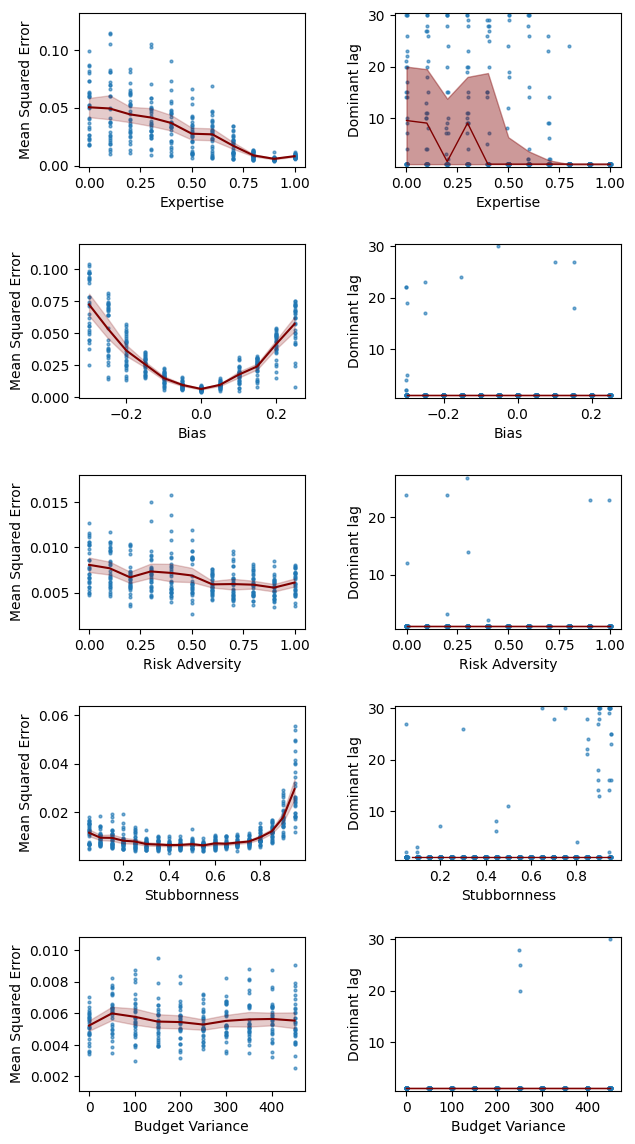

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

fig, ax = plt.subplots(len(results_dict.keys()), 2, figsize=(7, 14))
plt.subplots_adjust(hspace=0.5, wspace=0.4)
axs = ax.ravel()

i = 0
for k in results_dict.keys():
    if k == 'Exponetial budget':
        continue

    arr = results_dict[k]
    params = arr[:, 0]
    mse = arr[:, 1]

    # Left: MSE (same as before)
    axs[i].scatter(x=params, y=mse, s=4, alpha=0.6)
    sns.lineplot(x=params, y=mse, ax=axs[i], color='maroon')
    axs[i].set_xlabel(k.replace("_"," ").title())
    axs[i].set_ylabel('Mean Squared Error')
    y1, y2 = axs[i].get_ylim()
    axs[i].set_ylim(0.5 * y1, 1.1 * y2)

    i += 1

    dominant_lag = arr[:, 2]

    # Jitter scatter for readability
    jitter = (np.random.rand(len(params)) - 0.5) * ( (np.max(params) - np.min(params)) * 0.01 + 1e-6 )
    axs[i].scatter(x=params + jitter, y=dominant_lag, s=4, alpha=0.6)

    # Summary line: compute median and IQR in parameter bins
    df = pd.DataFrame({'param': params, 'lag': [int(x) for x in dominant_lag]})
    # choose bins: if param has few unique values, use them; otherwise use quantile bins
    if len(np.unique(params)) <= 12:
        # group by unique param values
        grp = df.groupby('param')
        print(grp)
        x_centers = np.array(list(grp.groups.keys()))
        med = grp['lag'].median().values
        q1 = grp['lag'].quantile(0.25).values
        q3 = grp['lag'].quantile(0.75).values
    else:
        # use 12 even quantile bins
        df['bin'] = pd.qcut(df['param'], q=12, duplicates='drop')
        grp = df.groupby('bin')
        # x center for each bin
        x_centers = grp['param'].median().values
        med = grp['lag'].median().values
        q1 = grp['lag'].quantile(0.25).values
        q3 = grp['lag'].quantile(0.75).values

    # Plot median line and IQR shading
    axs[i].plot(x_centers, med, color='maroon', linewidth=1)

    try:
        axs[i].fill_between(x_centers, q1, q3, color='maroon', alpha=0.4, step=None)
    except:
        pass

    axs[i].set_xlabel(k.replace("_"," ").title())
    axs[i].set_ylabel('Dominant lag')
    # tighten y-limits with small margin
    y_min, y_max = np.min(dominant_lag), np.max(dominant_lag)
    axs[i].set_ylim(max(y_min - 0.5, -0.5), y_max + 0.5)

    i += 1

plt.savefig('P1_results_combined.pdf', bbox_inches='tight')
plt.show()


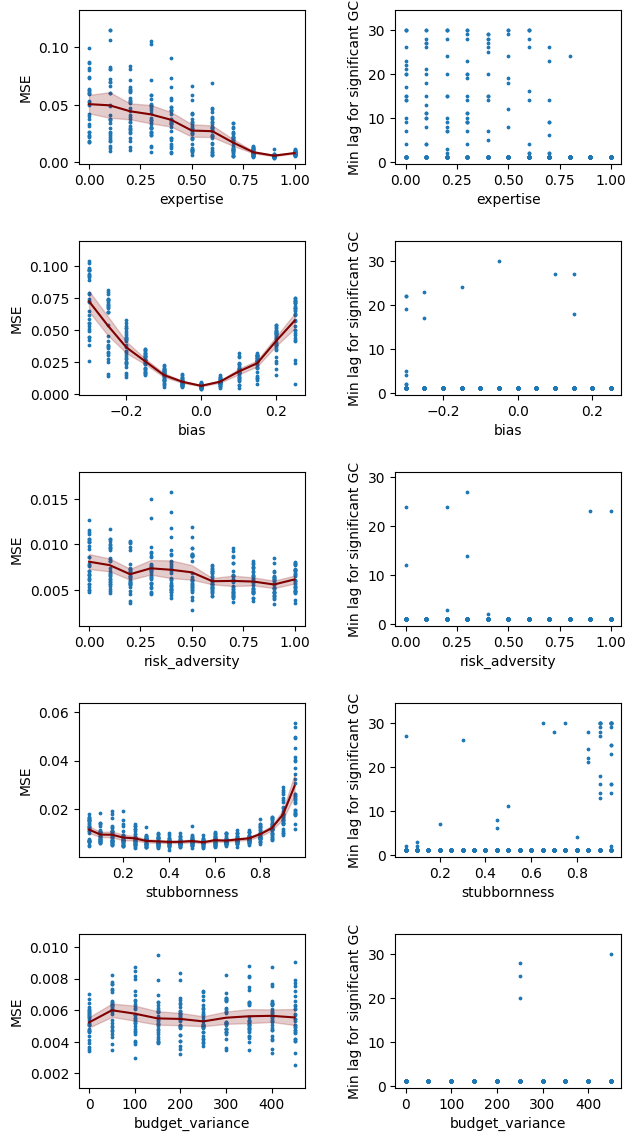

In [32]:
fig, ax = plt.subplots(len(results_dict.keys()),2,figsize=(7,14))
plt.subplots_adjust(hspace=0.5,wspace=0.4)
axs = ax.ravel()

i=0
for k in results_dict.keys():
    if k=='Exponetial budget':
        continue
#     arr=results_dict[k]:
#     rows, row_pos = np.unique(arr[:, 0], return_inverse=True)
#     cols, col_pos = np.unique(arr[:, 1], return_inverse=True)
#     pivoted_arr3 = np.zeros((len(rows), len(cols)))
#     pivoted_arr3[row_pos, col_pos] = arr[:, 2]
#     axs[i].boxplot(pivoted_arr3.T,positions=rows)
    axs[i].scatter(x=results_dict[k][:,0],y=results_dict[k][:,1],s=3)
    sns.lineplot(x=results_dict[k][:,0],y=results_dict[k][:,1],ax=axs[i],c='maroon')
    axs[i].set_xlabel(k)
    axs[i].set_ylabel('MSE')
    y1,y2=axs[i].get_ylim()
    axs[i].set_ylim(0.5*y1,1.1*y2)
    
    i+=1
    axs[i].scatter(x=results_dict[k][:,0],y=results_dict[k][:,2],s=3)
    # sns.lineplot(x=results_dict[k][:,0],y=results_dict[k][:,2],ax=axs[i],c='maroon')
    y1,y2=axs[i].get_ylim()
    axs[i].set_ylim(0.9*y1,1.1*y2)
    axs[i].set_xlabel(k)
    axs[i].set_ylabel('Min lag for significant GC')
    i+=1

# axs[0].set_title('MSE')
# axs[1].set_title('Maxmimum cross-correlation')
plt.savefig('P1_results_combined.pdf', bbox_inches='tight')

In [ ]:
import pickle

with open('results/plot1_simulation_results10O.json', 'wb') as fp:
    pickle.dump(results_dict, fp)

### Market shock

In [19]:
# Set initial input values to the betting market function
parameters = {'n_bettors': N_bettors, # The number of betting agents
                #'el_outcome': 1, # Q: Ultimate election outcome - assuming we know this to begin with and it does not change over time...for now this is implemented as a random walk of the probability...but should this be 0 or 1 instead? '''
            't_election': T_max, # Time until election takes place (ie. time horizon of betting)
            'initial_price': initial_price, # Initial market price (is this equivalent to probability of winning)
            'outcome_uncertainty': rw_variance} # This is a measure of how uncertain the true outcome is - ie. the volatility of the random walk election probability


expertise_values = np.linspace(0,1,N_bettors)

av_budget=100
budget_total = av_budget* N_bettors
N_whales = 1
whale_valuation = 0.6

expertise_whale = {}

for prop_whale in np.arange(0,0.55,0.1):
    
    whale_effect = []

    whale_budget = av_budget*N_bettors*prop_whale / (1-prop_whale)

    non_whale_bettors = [bettor(budget=av_budget, expertise=expertise_values[i]) for i in range(N_bettors)]
    whale_bettors = [bettor(budget=whale_budget, whale=True, market_valuation=whale_valuation) for _ in range(N_whales)]

    parameters.update({'bettors': non_whale_bettors + whale_bettors})

    for _ in range(n_iter_):
        market_record = run_market(**parameters)

        whale_effect.append((np.array(market_record['price_history']) -  np.array(market_record['gen_el'])))

    expertise_whale[prop_whale] = whale_effect

In [20]:
times = np.arange(T_max+1)
vals = []
for k,val in expertise_whale.items():
    for v in val:
        for x in range(T_max+1):
            vals.append([k,v[x],times[x]])


df_plot = pd.DataFrame(vals, columns = ['PropWhale','SE','T'])

### whales in the market

In [ ]:
mv=0.7
N=100

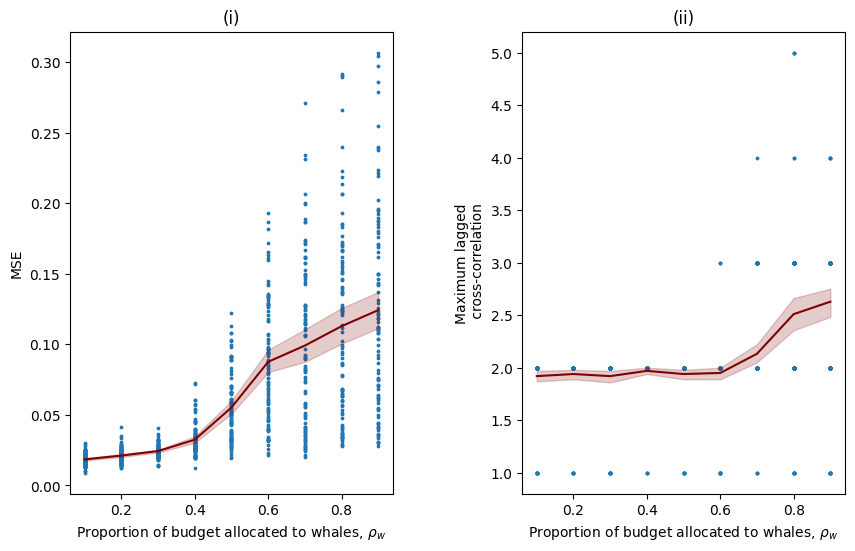

In [ ]:

r_arr = np.array(results)
with open(f'whale_{mv}_{N}.pkl', 'rb') as f:
    results = pickle.load(f)

# modify the simulation to multiprocess
fig, axs = plt.subplots(1,2,figsize=(10,6))
plt.subplots_adjust(wspace=0.4)
axs[0].scatter(x=results[:,0],y=results[:,1],s=3)
sns.lineplot(x=results[:,0],y=results[:,1],c='maroon',ax=axs[0])
axs[0].set_ylabel('MSE')
axs[0].set_xlabel(r'Proportion of budget allocated to whales, $\rho_w$')
# plt.suptitle(f'Single whale with internal valuation of {mv}')
axs[0].set_title('(i)')
axs[1].set_title('(ii)')
axs[1].scatter(x=results[:,0],y=results[:,2],s=3)
sns.lineplot(x=results[:,0],y=results[:,2],c='maroon',ax=axs[1])
axs[1].set_ylabel('Maximum lagged\n cross-correlation')
axs[1].set_xlabel(r'Proportion of budget allocated to whales, $\rho_w$')

plt.savefig(f'whales_{mv}_{N}.pdf', bbox_inches='tight')

# P4 Herding behaviour

In [9]:
cases = [(0,0,1),(0.5,0,0.5),(0,0.5,0.5),(0.25,0.25,0.5)]

In [10]:
av_budget=100



alpha_store_shock = {}

N_50 = N_bettors//2
N_25 = N_bettors // 4
var_save = []
case_save = []
for case in cases:
    alpha_effect = []
    parameters = {'n_bettors': N_bettors, # The number of betting agents
                #'el_outcome': 1, # Q: Ultimate election outcome - assuming we know this to begin with and it does not change over time...for now this is implemented as a random walk of the probability...but should this be 0 or 1 instead? '''
            't_election': T_max, # Time until election takes place (ie. time horizon of betting)
            'initial_price': initial_price, # Initial market price (is this equivalent to probability of winning)
            'outcome_uncertainty': rw_variance} # This is a measure of how uncertain the true outcome is - ie. the volatility of the random walk election probability


    b_numbers = N_bettors*np.array(case)
    b_numbers = [int(x) for x in b_numbers]

    alpha_1_bettors = [bettor(budget=av_budget, market_imitation = 1) for i in range(b_numbers[0])]
    alpha_neg1_bettors = [bettor(budget=av_budget, market_imitation = -1) for i in range(b_numbers[1])]
    no_alpha_bettors = [bettor(budget=av_budget, market_imitation = 0) for i in range(b_numbers[2])]

    parameters.update({'bettors': alpha_1_bettors + alpha_neg1_bettors + no_alpha_bettors})

    for _ in range(n_iter_):
        market_record = run_market(**parameters)

        alpha_effect.append((np.array(market_record['price_history']) -  np.array(market_record['gen_el'])))
        var_save.append(np.var(market_record['price_history']))
        case_save.append(case)

    alpha_store_shock[case] = alpha_effect

In [11]:
case_map = {(0,0,1):'No Alpha', (0.5,0,0.5):'50% Pro-Alpha', (0,0.5,0.5):'50% Anti-Alpha', (0.25,0.25,0.5):'25% Pro-Alpha \n 25% Anti-Alpha'}
df_plot_var['Case'] = df_plot_var['Case'].map(case_map) 

NameError: name 'df_plot_var' is not defined

In [ ]:
df_plot_var

,Var,Case
0,0.033326,No Alpha
1,0.053723,No Alpha
2,0.012440,No Alpha
3,0.023285,No Alpha
4,0.016966,No Alpha
...,...,...
115,0.008237,25% Pro-Alpha \n 25% Anti-Alpha
116,0.040523,25% Pro-Alpha \n 25% Anti-Alpha
117,0.011749,25% Pro-Alpha \n 25% Anti-Alpha
118,0.065539,25% Pro-Alpha \n 25% Anti-Alpha


/var/folders/wp/758jq81s3hs0jlp8_31261sc0000gn/T/ipykernel_24983/2315947269.py:3: UserWarning: The palette list has more values (11) than needed (4), which may not be intended.
  sns.boxplot(data=df_plot_var, y='Var', hue='Case', palette = colors, fliersize=1, dodge=0.8)


<Axes: ylabel='Var'>

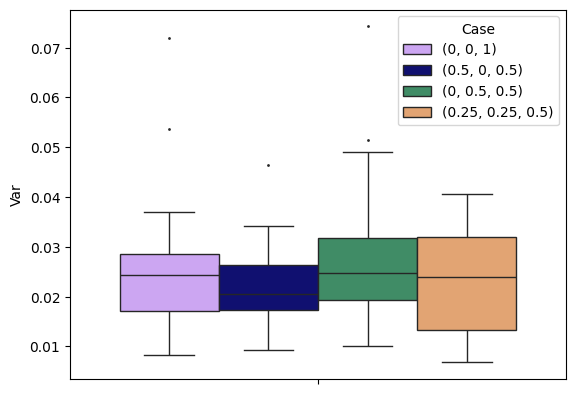

In [ ]:
df_plot_var = pd.DataFrame({'Var':var_save, 'Case':case_save})

sns.boxplot(data=df_plot_var, y='Var', hue='Case', palette = colors, fliersize=1, dodge=0.8)

In [172]:
times = np.arange(T_max+1)
vals = []
for k,val in alpha_store_shock.items():

    for v in val:
        for x in range(T_max+1):
            vals.append([k,v[x],times[x]])


df_plot = pd.DataFrame(vals, columns = ['Case','SE','T'])


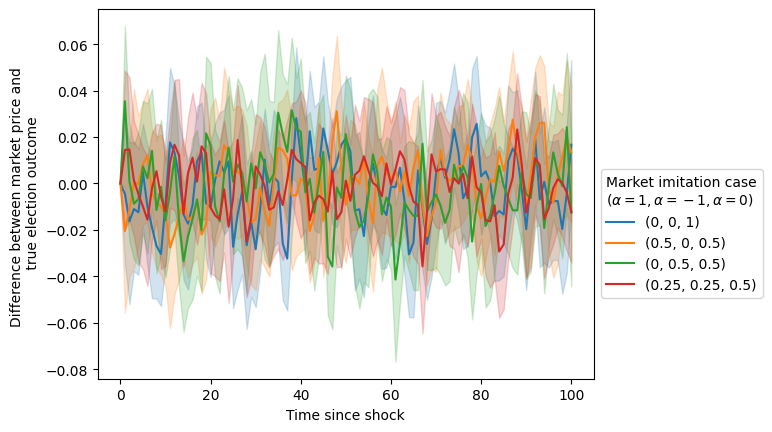

In [173]:

sns.lineplot(data = df_plot, x='T', y='SE',hue='Case')
plt.xlabel('Time since shock')
plt.legend(title = 'Market imitation case\n'+ r'$(\alpha=1,\alpha=-1,\alpha=0)$', loc='lower left', bbox_to_anchor=(1,0.2))
plt.ylabel('Difference between market price and \n true election outcome')
plt.savefig('MarketImitationShock.pdf')

## now with one whale

In [167]:
cases = [(0,0,1),(0.5,0,0.5),(0,0.5,0.5),(0.25,0.25,0.5)]

KeyboardInterrupt: 

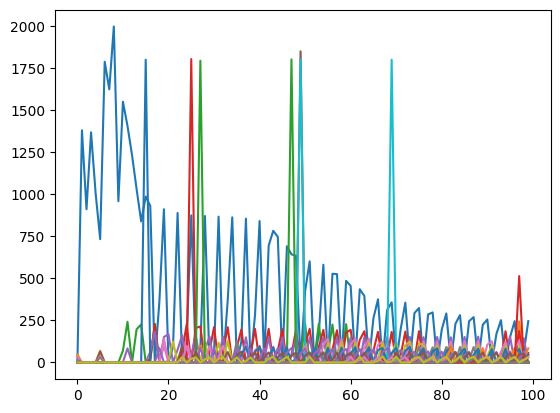

In [ ]:
N_bettors = 20
av_budget=100
prop_whale = 0.3
N_whales = 1



alpha_store_shock = {}


for case in cases:
    alpha_effect = []
    parameters = {'n_bettors': N_bettors, # The number of betting agents
                #'el_outcome': 1, # Q: Ultimate election outcome - assuming we know this to begin with and it does not change over time...for now this is implemented as a random walk of the probability...but should this be 0 or 1 instead? '''
            't_election': T_max, # Time until election takes place (ie. time horizon of betting)
            'initial_price': initial_price, # Initial market price (is this equivalent to probability of winning)
            'outcome_uncertainty': rw_variance} # This is a measure of how uncertain the true outcome is - ie. the volatility of the random walk election probability


    b_numbers = N_bettors*np.array(case)
    b_numbers = [int(x) for x in b_numbers]

    alpha_1_bettors = [bettor(budget=av_budget, market_imitation = 1) for i in range(b_numbers[0])]
    alpha_neg1_bettors = [bettor(budget=av_budget, market_imitation = -1) for i in range(b_numbers[1])]
    no_alpha_bettors = [bettor(budget=av_budget, market_imitation = 0) for i in range(b_numbers[2])]

    # whale
    whale_budget = av_budget*N_bettors*prop_whale / (1-prop_whale)
    whale_bettors = [bettor(budget=whale_budget, whale=True, market_valuation=1) for _ in range(N_whales)]

    parameters.update({'bettors': alpha_1_bettors + alpha_neg1_bettors + no_alpha_bettors + whale_bettors})

    for _ in range(n_iter_):
        market_record = run_market(**parameters)

        alpha_effect.append((np.array(market_record['price_history']) -  np.array(market_record['gen_el'])))

        var_save.append(np.var(market_record['price_history']))

    alpha_store_shock[case] = alpha_effect

In [ ]:
times = np.arange(T_max+1)
vals = []
for k,val in alpha_store_shock.items():
    for v in val:
        for x in range(T_max+1):
            vals.append([k,v[x],times[x]])


df_plot = pd.DataFrame(vals, columns = ['Case','SE','T'])


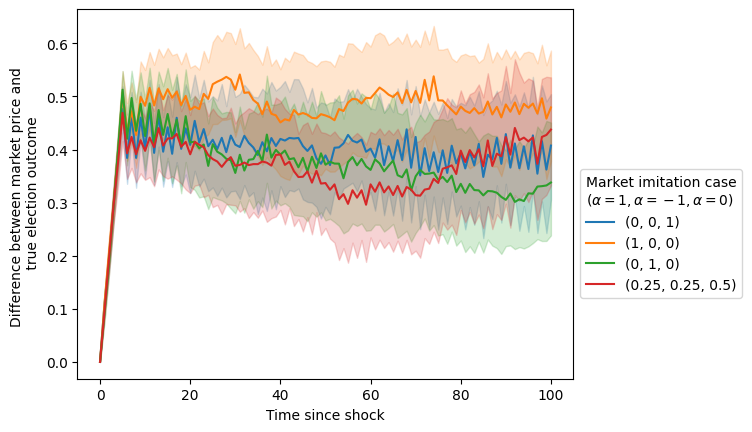

In [ ]:

sns.lineplot(data = df_plot, x='T', y='SE',hue='Case')
plt.xlabel('Time since shock')
plt.legend(title = 'Market imitation case\n'+ r'$(\alpha=1,\alpha=-1,\alpha=0)$', loc='lower left', bbox_to_anchor=(1,0.2))
plt.ylabel('Difference between market price and \n true election outcome')
plt.savefig('MarketImitationShockWhale.pdf')

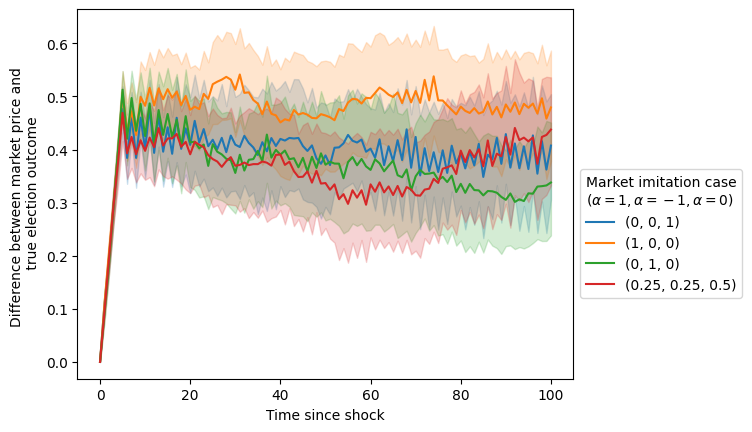

In [ ]:

sns.lineplot(data = df_plot, x='T', y='SE',hue='Case')
plt.xlabel('Time since shock')
plt.legend(title = 'Market imitation case\n'+ r'$(\alpha=1,\alpha=-1,\alpha=0)$', loc='lower left', bbox_to_anchor=(1,0.2))
plt.ylabel('Difference between market price and \n true election outcome')
plt.savefig('MarketImitationShockWhale.pdf')

## nice market picture

In [12]:
cases = [(0,0,1),(1,0,0),(0,1,0),(0.25,0.25,0.5)]

In [13]:
np.random.seed(41)
T_max=100

In [14]:
gen_el_res = gen_election(0.5, T_max, rw_variance)

<Axes: >

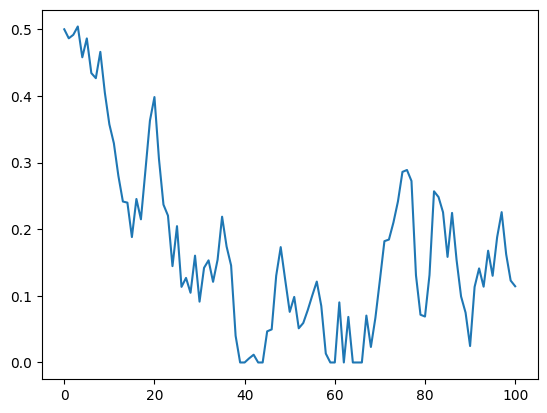

In [15]:
sns.lineplot(gen_el_res)

In [16]:
N_bettors = 100
av_budget=1000
prop_whale = 0.2
N_whales = 1
T_max=100


records = {}


for case in cases:
    alpha_effect = []
    parameters = {'n_bettors': N_bettors, # The number of betting agents
                #'el_outcome': 1, # Q: Ultimate election outcome - assuming we know this to begin with and it does not change over time...for now this is implemented as a random walk of the probability...but should this be 0 or 1 instead? '''
            't_election': T_max, # Time until election takes place (ie. time horizon of betting)
            'initial_price': initial_price, # Initial market price (is this equivalent to probability of winning)
            'outcome_uncertainty': rw_variance,
            'gen_el' : gen_el_res,
            'k':3} # This is a measure of how uncertain the true outcome is - ie. the volatility of the random walk election probability


    b_numbers = N_bettors*np.array(case)
    b_numbers = [int(x) for x in b_numbers]

    alpha_1_bettors = [bettor(budget=av_budget, market_imitation = 1) for i in range(b_numbers[0])]
    alpha_neg1_bettors = [bettor(budget=av_budget, market_imitation = -1) for i in range(b_numbers[1])]
    no_alpha_bettors = [bettor(budget=av_budget, market_imitation = 0) for i in range(b_numbers[2])]



    # whale
    whale_budget = av_budget*(np.sum(b_numbers))* prop_whale / (1-prop_whale)
    whale_bettors = [bettor(budget=whale_budget, whale=True, market_valuation=0.2) for _ in range(N_whales)]

    parameters.update({'bettors': alpha_1_bettors + alpha_neg1_bettors + no_alpha_bettors + whale_bettors})

    market_record = run_market_fixed_el(**parameters)

    records[case] = market_record


TypeError: run_market_fixed_el() got an unexpected keyword argument 'k'

In [57]:
rec = records[case]
step = False
scale_fact = 10

In [58]:
times = np.arange(T_max+1)

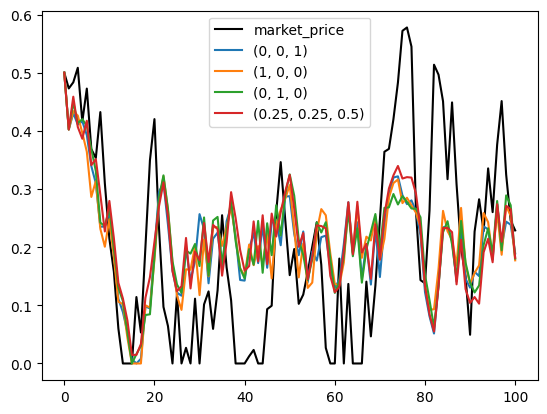

In [61]:
sns.lineplot(x=times, y=gen_el_res, c='black', label='market_price')

for case in cases:
    ph =records[case]['price_history']
    sns.lineplot(x=times, y=ph, label = case)